In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# 1. Data Voorbereiding
# Laad de data
X_train = pd.read_csv('alle_kranten_X_train.csv')  # Laad trainingskenmerken
X_test = pd.read_csv('alle_kranten_X_test.csv')    # Laad testkenmerken
y_train = pd.read_csv('alle_kranten_y_train.csv')  # Laad trainingsdoelvariabele
y_test = pd.read_csv('alle_kranten_y_test.csv')    # Laad testdoelvariabele

# Controleer data
print(f"Train X shape: {X_train.shape}, Train y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}, Test y shape: {y_test.shape}")


Train X shape: (170772, 177), Train y shape: (170772, 1)
Test X shape: (42694, 177), Test y shape: (42694, 1)


In [23]:
# Log-transformatie van de doelvariabele
y_train_log = np.log1p(y_train.squeeze())  # Log-transformatie
y_test_log = np.log1p(y_test.squeeze())    # Log-transformatie

# Schaal de kenmerken (X)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)


In [31]:
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Inputlaag
    Dense(512, activation='relu'),           # Verborgen laag 1
    Dropout(0.3),                            # Dropout
    Dense(256, activation='relu'),           # Verborgen laag 2
    Dropout(0.2),                            # Dropout
    Dense(128, activation='relu'),           # Verborgen laag 3
    Dense(64, activation='relu'),            # Verborgen laag 4
    Dense(32, activation='relu'),            # Verborgen laag 5
    Dense(1)                                 # Outputlaag (regressie)
])


# Compile het model
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(), metrics=['mae', 'mse'])

# 3. Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 4. Train het model
history = model.fit(
    X_train_scaled, y_train_log,
    validation_data=(X_test_scaled, y_test_log),  # Gebruik testdata voor validatie
    epochs=50, batch_size=32, callbacks=[early_stopping], verbose=1
)

Epoch 1/50
5337/5337 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - loss: 0.2437 - mae: 0.5462 - mse: 0.6646 - val_loss: 0.1678 - val_mae: 0.4378 - val_mse: 0.3684
Epoch 2/50
5337/5337 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 0.1698 - mae: 0.4420 - mse: 0.3747 - val_loss: 0.1670 - val_mae: 0.4392 - val_mse: 0.3663
Epoch 3/50
5337/5337 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - loss: 0.1642 - mae: 0.4334 - mse: 0.3611 - val_loss: 0.1640 - val_mae: 0.4327 - val_mse: 0.3613
Epoch 4/50
5337/5337 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - loss: 0.1610 - mae: 0.4289 - mse: 0.3536 - val_loss: 0.1668 - val_mae: 0.4342 - val_mse: 0.3670
Epoch 5/50
5337/5337 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 0.1586 - mae: 0.4236 - mse: 0.3493 - val_loss: 0.1618 - val_mae: 0.4272 - val_mse: 0.3561
Epoch 6/50
5337/5337 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 0.1563 - mae: 0.4212 - mse: 0.3423 - val_loss: 0.1632 - val_mae: 0.4273 - val_mse: 0.3597
Epoch 7/50
5337/5337 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 0.1546 - mae: 0.418

In [32]:
# 7. Maak voorspellingen
y_pred_log = model.predict(X_test_scaled)  # Voorspellingen op log-schaal
y_pred = np.expm1(y_pred_log)              # Inverse log-transformatie
y_test_original = np.expm1(y_test_log)     # Inverse log-transformatie van testdoelvariabele

# 8. Evaluatie van de resultaten
# Bereken RMSE en R² op originele schaal
rmse = sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)

print(f"RMSE op originele schaal: {rmse}")
print(f"R²-score: {r2}")

1335/1335 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
RMSE op originele schaal: 46.638609437737
R²-score: 0.25326586321361333


Top-10 belangrijkste features:
                 Feature  Importance
176   subsections_labels    0.237262
3             author_ids    0.127553
0                  brand    0.024205
5                   date    0.020756
4           main_section    0.019999
21               help_me    0.016088
35                 sport    0.014475
24            vermaak_me    0.014232
23   hou_me_op_de_hoogte    0.013441
55        human_interest    0.013092


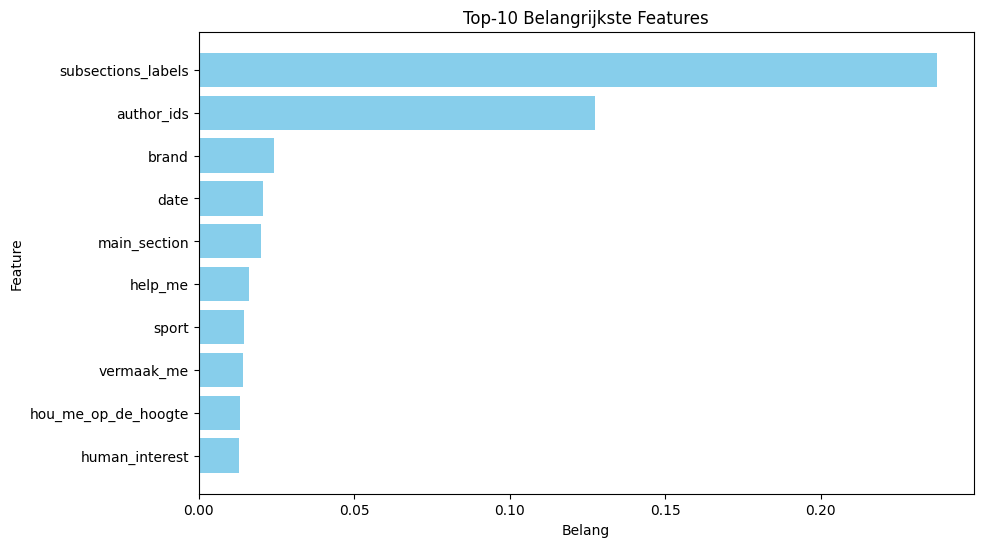

In [34]:
# Importeer benodigde libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# 1. Laad de trainingsdata
X_train = pd.read_csv('alle_kranten_X_train.csv')  # Trainingskenmerken
y_train = pd.read_csv('alle_kranten_y_train.csv')  # Trainingsdoelvariabele

# 2. Schaal de kenmerken
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 3. Train een Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train.values.ravel())  # Train het model

# 4. Bereken feature importances
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

# Combineer de feature-importances met de namen
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 5. Print de top-10 belangrijkste features
print("Top-10 belangrijkste features:")
print(importance_df.head(10))

# 6. Visualiseer de top-10 belangrijkste features
top_features = importance_df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Belang')
plt.ylabel('Feature')
plt.title('Top-10 Belangrijkste Features')
plt.gca().invert_yaxis()  # Draai de y-as zodat de belangrijkste bovenaan staat
plt.show()
